In [43]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn.cluster as sk
from sklearn import metrics
from sklearn.metrics import roc_curve, roc_auc_score

plt.close('all')

In [61]:
def calculate_auc(x, y):
    """
    Calculates the integral of a curve stored in points y vs x using the trapezoidal rule.
    """
    assert len(x) == len(y)
    N = len(x)
    area = 0
    i_sorted = np.argsort(x)
    for i in range(0, N - 1):
        dx = x[i_sorted[i + 1]] - x[i_sorted[i]]
        yi = (y[i_sorted[i]] + y[i_sorted[i + 1]]) / 2
        area += yi * dx
    return area

In [83]:
def calculate_sensitivity_specificity(test_results, true_labels, thresholds=None):
    """
    Calculate sensitivity and specificity for different thresholds.

    Parameters:
    - test_results: NumPy array or Pandas Series, test results.
    - true_labels: NumPy array or Pandas Series, true labels (0 for negative, 1 for positive).
    - thresholds: NumPy array or None, thresholds to evaluate. If None, use sorted unique values of test_results.

    Returns:
    - thresholds: NumPy array, evaluated thresholds.
    - sensitivity: NumPy array, sensitivity values.
    - specificity: NumPy array, specificity values.
    """
    #aggunge 0 come soglia
    if thresholds is None:
        thresholds = np.sort(np.unique(np.concatenate(([0], test_results))))
    sensitivity_list = []
    specificity_list = []

    for thresh in thresholds:
        true_positives = np.sum((test_results >= thresh) & (true_labels == 1))
        false_negatives = np.sum((test_results < thresh) & (true_labels == 1))
        true_negatives = np.sum((test_results < thresh) & (true_labels == 0))
        false_positives = np.sum((test_results >= thresh) & (true_labels == 0))

        sensitivity_list.append(true_positives / (true_positives + false_negatives))
        specificity_list.append(true_negatives / (true_negatives + false_positives))

    return thresholds, sensitivity_list, specificity_list

In [98]:
xx = pd.read_csv("covid_serological_results.csv")

# Remove rows with swab test = 1

xx = xx[xx['COVID_swab_res'] != 1]

# Replace swab test = 2 with swab test = 1
#Uncertain values are removed, so the only values are - 0 -> negative - 1 -> positive IgG_test1_titre: test #1 Immunoglobulin G values in range [2.5, 314] IgG_test2_titre: test #2 Immunoglobulin G values in range [0, 9.71]
xx.loc[xx.COVID_swab_res == 2, 'COVID_swab_res'] = 1 # and 2 is then replaced with 1

swab = xx['COVID_swab_res'].values
Test2 = xx['IgG_Test2_titre'].values
Test1 = xx['IgG_Test1_titre'].values

# Describe the data
description = xx.describe()

# Print the descriptive statistics
print(description)

       COVID_swab_res  IgG_Test1_titre  IgG_Test2_titre
count      862.000000       862.000000       862.000000
mean         0.082367         9.374849         0.803515
std          0.275082        20.431089         2.064172
min          0.000000         2.500000         0.000000
25%          0.000000         2.500000         0.020000
50%          0.000000         2.500000         0.030000
75%          0.000000         5.175000         0.070000
max          1.000000       314.000000         9.690000


'The plots in the diagonal simply represent the distribution of the values of the i-th test, other plots shows, symmetrically along the diagonal, the result of a test given the test value. For example, the first plot in the second row shows the values of Immunoglobulin G for each negative and positive COVID-19 test.'

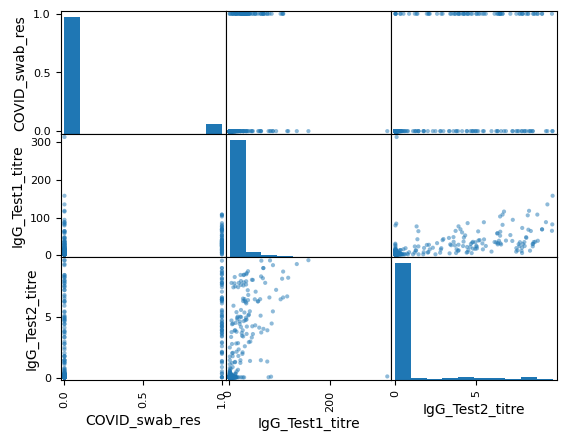

In [85]:
# Use scatter_matrix to plot a scatter plot matrix
# Exclude 'swab' from the matrix
pd.plotting.scatter_matrix(xx)

"""The plots in the diagonal simply represent the distribution of the values of the i-th test, other plots shows, symmetrically along the diagonal, the result of a test given the test value. For example, the first plot in the second row shows the values of Immunoglobulin G for each negative and positive COVID-19 test."""

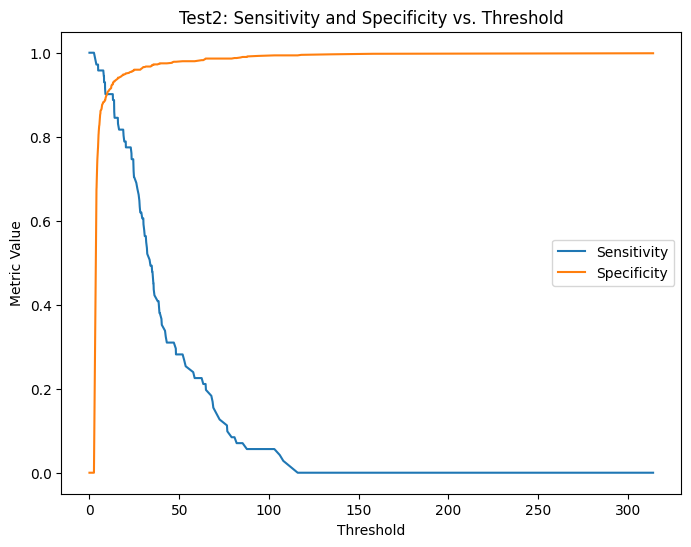

Best Threshold for Test1: 7.71
Sensitivity for Test1 with Best Threshold: 0.9577464788732394
Specificity for Test1 with Best Threshold: 0.8824273072060683


In [89]:
# Calcola sensitivity e specificity per Test1
thresholds_1, sensitivity_1, specificity_1 = calculate_sensitivity_specificity(Test1, swab)

# Plot sensitivity e specificity versus threshold
plt.figure(figsize=(8, 6))
plt.plot(thresholds_1, sensitivity_1, label='Sensitivity')
plt.plot(thresholds_1, specificity_1, label='Specificity')
plt.xlabel('Threshold')
plt.ylabel('Metric Value')
plt.title('Test2: Sensitivity and Specificity vs. Threshold')
plt.legend()
plt.show()

# Converti le liste in array NumPy
sensitivity_1 = np.array(sensitivity_1)
specificity_1 = np.array(specificity_1)

# Trova la best threshold basandoti sulla somma di sensibilità e specificità
sum_metrics_Test1 = np.array(sensitivity_1) + np.array(specificity_1)
best_threshold_Test1 = thresholds_1[np.argmax(sum_metrics_Test1)]

# Stampa la best threshold
print("Best Threshold for Test1:", best_threshold_Test1)

# Calcola sensitivity e specificity per Test1 utilizzando la best threshold di Test1
thresholds_1, sensitivity_1, specificity_1 = calculate_sensitivity_specificity(Test1, swab, thresholds=[best_threshold_Test1])

# Estrai i valori di sensibilità e specificità per Test1
sensitivity_best_threshold_Test1 = sensitivity_1[0]
specificity_best_threshold_Test1 = specificity_1[0]

# Stampa i risultati
print("Sensitivity for Test1 with Best Threshold:", sensitivity_best_threshold_Test1)
print("Specificity for Test1 with Best Threshold:", specificity_best_threshold_Test1)

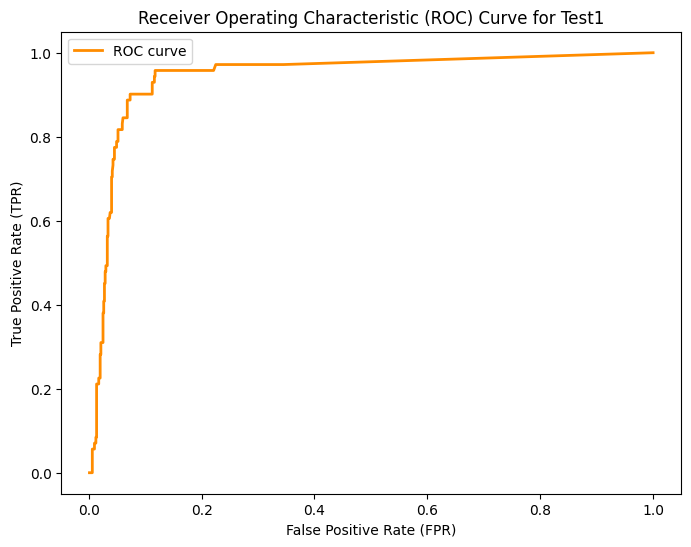

In [90]:
# Supponendo che tu abbia già ottenuto i valori di tpr e specificity dalla tua funzione
thresholds_1, sensitivity_1, specificity_1 = calculate_sensitivity_specificity(Test1, swab)

# Calcolo del FPR
fpr_1 = 1 - np.array(specificity_1)


# Plot ROC curve per Test1
plt.figure(figsize=(8, 6))
plt.plot(fpr_1, sensitivity_1, color='darkorange', lw=2, label='ROC curve')
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('Receiver Operating Characteristic (ROC) Curve for Test1')
plt.legend()
plt.show()


In [91]:

# Calcolo della curva ROC per Test2
auc_test1_sklearn = metrics.roc_auc_score(swab, Test1)

print("AUC for Test1 (Scikit-Learn):", auc_test1_sklearn)

# Calcola l'AUC per Test1
auc_test1 = calculate_auc(fpr_1, sensitivity_1)
print("AUC for Test1:", auc_test1)

print(f'Error on roc_auc: roc_auc - true_roc_auc = { auc_test1 - auc_test1_sklearn}')


AUC for Test1 (Scikit-Learn): 0.9434661063727497
AUC for Test1: 0.9435284272003707
Error on roc_auc: roc_auc - true_roc_auc = 6.232082762092084e-05


In [92]:

# Trova la soglia per ottenere sensibilità e specificità uguali
equal_sensitivity_specificity_threshold = thresholds_1[np.argmin(np.abs(sensitivity_1 - (1 - fpr_1)))]

# Stampa la soglia
print("Threshold for Equal Sensitivity and Specificity:", equal_sensitivity_specificity_threshold)

# Calcolo di sensitivity e specificity per la soglia di uguaglianza
true_positives_equal = np.sum((Test1 >= equal_sensitivity_specificity_threshold) & (swab == 1))
false_negatives_equal = np.sum((Test1 < equal_sensitivity_specificity_threshold) & (swab == 1))
true_negatives_equal = np.sum((Test1 < equal_sensitivity_specificity_threshold) & (swab == 0))
false_positives_equal = np.sum((Test1 >= equal_sensitivity_specificity_threshold) & (swab == 0))

sensitivity_equal = true_positives_equal / (true_positives_equal + false_negatives_equal)
specificity_equal = true_negatives_equal / (true_negatives_equal + false_positives_equal)

print("Specificity for Equal Sensitivity and Specificity Threshold (Test1):", specificity_equal)
print("Sensitivity for Equal Sensitivity and Specificity Threshold (Test1):", sensitivity_equal)







Threshold for Equal Sensitivity and Specificity: 9.75
Specificity for Equal Sensitivity and Specificity Threshold (Test1): 0.9013906447534766
Sensitivity for Equal Sensitivity and Specificity Threshold (Test1): 0.9014084507042254
Point on ROC Curve for Equal Sensitivity and Specificity Threshold: (0.09860935524652337, 0.9014084507042254)


Point on ROC Curve for Equal Sensitivity and Specificity Threshold: (0.09860935524652337, 0.9014084507042254)


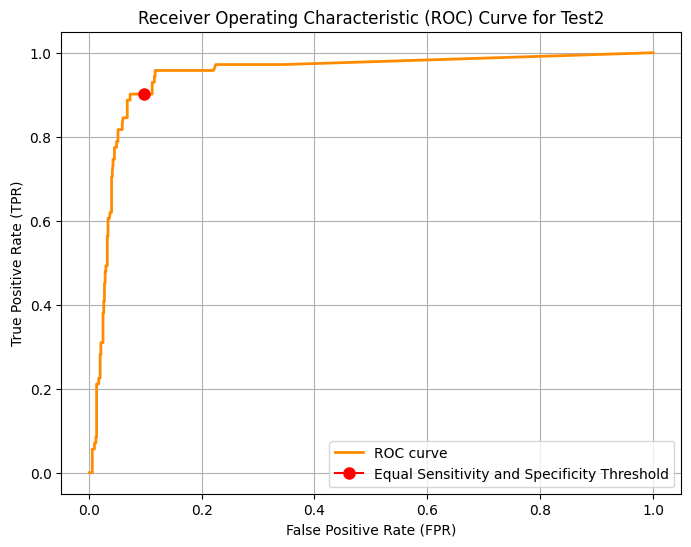

In [99]:
# Trova il punto sulla curva ROC corrispondente alla soglia di uguaglianza
point_on_roc_curve = (1 - specificity_equal, sensitivity_equal)

# Stampa le coordinate del punto sulla curva ROC
print("Point on ROC Curve for Equal Sensitivity and Specificity Threshold:", point_on_roc_curve)

# Plot ROC curve per Test2
plt.figure(figsize=(8, 6))
plt.plot(fpr_1, sensitivity_1, color='darkorange', lw=2, label='ROC curve')
plt.plot(point_on_roc_curve[0], point_on_roc_curve[1], marker='o', markersize=8, color="red", label='Equal Sensitivity and Specificity Threshold')
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('Receiver Operating Characteristic (ROC) Curve for Test2')
plt.legend()
plt.grid(True)
plt.show()

In [96]:
# Specifica la sensibilità desiderata
desired_sensitivity = 0.8  # Imposta la sensibilità desiderata al valore desiderato

# Converte le liste di sensibilità in array NumPy
sensitivity_1 = np.array(sensitivity_1)

# Calcola la differenza tra la sensibilità desiderata e la sensibilità effettiva per ciascuna soglia
sensitivity_difference = np.abs(sensitivity_1 - desired_sensitivity)

# Trova la soglia che minimizza questa differenza
sensitivity_threshold = thresholds_1[np.argmin(sensitivity_difference)]

# Stampa la soglia
print("Threshold for Desired Sensitivity:", sensitivity_threshold)

Threshold for Desired Sensitivity: 19.0


In [97]:

# Specifica la specificità desiderata
desired_specificity = 0.8  # Imposta la specificità desiderata al valore desiderato

# Converte le liste di specificità in array NumPy
specificity_1 = np.array(specificity_1)

# Calcola la differenza tra la specificità desiderata e la specificità effettiva per ciascuna soglia
specificity_difference = np.abs(specificity_1 - desired_specificity)

# Trova la soglia che minimizza questa differenza
specificity_threshold = thresholds_1[np.argmin(specificity_difference)]

# Stampa la soglia
print("Threshold for Desired Specificity:", specificity_threshold)

Threshold for Desired Specificity: 5.01
